# TinyHiera with multiloader

In [1]:
plt.plot(val_)

NameError: name 'plt' is not defined

In [2]:
blocksize=8
dim_head=64
num_heads=2
batch_size=64

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from os import path

from torch import nn
from torch.nn import functional as F
from torch.nn.functional import scaled_dot_product_attention
from torch.nn.attention import SDPBackend, sdpa_kernel
from tqdm import tqdm
from einops import rearrange
from torch.optim import AdamW, Adam

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from omegaconf import OmegaConf, open_dict
from experanto.datasets import ChunkDataset, SimpleChunkedDataset
from experanto.utils import LongCycler, MultiEpochsDataLoader
from experanto.dataloaders import get_multisession_dataloader

## Load Config Object from .yaml file

### Modify the config

In [3]:
paths = ['dynamic29513-3-5-Video-full',
         'dynamic29514-2-9-Video-full',
         'dynamic29755-2-8-Video-full',
         'dynamic29647-19-8-Video-full',
         'dynamic29156-11-10-Video-full',
         'dynamic29623-4-9-Video-full',
         'dynamic29515-10-12-Video-full',
         'dynamic29234-6-9-Video-full',
         'dynamic29712-5-9-Video-full',
         'dynamic29228-2-10-Video-full'
        ]
full_paths = [path.join("/data/mouse_polly/", f) for f in paths]
from experanto.configs import DEFAULT_CONFIG as cfg
cfg.dataset.global_chunk_size = blocksize
cfg.dataset.global_sampling_rate = 8
cfg.dataset.modality_config.screen.include_blanks=True
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}
cfg.dataset.modality_config.screen.transforms.Resize.size = [72, 128]
cfg.dataset.modality_config.responses.transforms.standardize=False

cfg.dataloader.num_workers=4
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=batch_size
cfg.dataloader.pin_memory=True
# the multiple dataloader is an iterator that returns a tuple of (key, batch)
train_dl = get_multisession_dataloader(full_paths, cfg)

# Hiera

In [5]:
import torch
from hiera import Hiera
tiny_hiera = Hiera(input_size=(blocksize,72, 128),
                     num_heads=2,
                     embed_dim=128,
                     stages=(2, 2), 
                     q_pool=1, 
                     in_chans=1,
                     q_stride=(1, 2, 2),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(3, 8, 8),
                     patch_stride=(2, 4, 4),
                     patch_padding=(1, 3, 3),
                     sep_pos_embed=True,)
#tiny_hiera = torch.compile(tiny_hiera).cuda().to(torch.bfloat16);
tiny_hiera = tiny_hiera.cuda().to(torch.float32);
example_in = torch.ones(8,1,8,72, 128).to("cuda", torch.float32)
out = tiny_hiera(example_in, return_intermediates=True);
features = out[-1][-1]
features.shape


torch.Size([8, 4, 9, 16, 256])

In [6]:
yo=0
for n, p in tiny_hiera.named_parameters():
    yo+=torch.numel(p)
yo

2266984

In [7]:
class IndexedLinearReadout(nn.Module):
    """
    Readout module for MTM models with selectable weights based on 
    input IDs. Based on :class:`torch.nn.Linear`.
    """
    def __init__(
        self,
        unique_ids: int,
        in_features: int = 384,
        out_features: int = 1,
        dim_head=32,
        num_heads=4,
        bias: bool = True,
        device="cuda",
        dtype=torch.float32,
        init_std: float = 0.02,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.unique_ids = unique_ids
        self.in_features = in_features
        self.out_features = out_features
        
        self.init_std = init_std

        self.query = nn.Parameter(
            torch.empty(1, num_heads, unique_ids, dim_head, **factory_kwargs)
        )
        self.weight = nn.Parameter(
            torch.empty(unique_ids, in_features, out_features, **factory_kwargs)
        )
        if bias:
            self.bias = nn.Parameter(
                torch.empty(1, unique_ids, out_features, **factory_kwargs)
            )
        else:
            self.register_parameter('bias', None)
        self.init_weights()

    def init_weights(self, cutoff_factor: int = 3):
        """See `TorchTitan <https://github.com/pytorch/torchtitan/blob/40a10263c5b3468ffa53b3ac98d80c9267d68155/torchtitan/models/llama/model.py#L403>`__."""
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.weight,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.query,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        if self.bias is not None:
            self.bias.data.zero_()

In [12]:
class MouseHieraSmall(nn.Module):
    def __init__(self,
                 backbone,
                 dls,
                 t=16,
                 dim=512,
                 dim_head=32,
                 num_heads=4):
        super().__init__()
        self.backbone=backbone
        self.num_heads=num_heads
        self.dim_head=dim_head
        self.wk = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.wv = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.neuron_proj = nn.Linear(dim_head * num_heads, t, bias=False)
        self.readout = nn.ModuleDict()
        self.activation = nn.Softplus(beta=0.1, )
        for k, v in dls.loaders.items():
            n_neurons = next(iter(v))["responses"].shape[-1]
            self.readout[k] = IndexedLinearReadout(n_neurons, 
                                                   in_features=dim_head*num_heads,
                                                   dim_head=dim_head, 
                                                   num_heads=num_heads, 
                                                   out_features=1)
    
    def forward(self, x, key):
        x = self.backbone(x, return_intermediates=True)[1][-1]
        b, t, h, w, d = x.shape
        seq_len = t*h*w
        x = x.view(b, -1, d)
        k, v = self.wk(x), self.wv(x)
        q = self.readout[key].query 
        n = q.shape[2] # number of neurons
        q = q.tile(b, 1, 1, 1)
        k = k.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2)
        v = v.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2)
        with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
            o = F.scaled_dot_product_attention(q, k, v)
        o = o.transpose(1,2).contiguous().view(b, -1, self.num_heads * self.dim_head)
        o = self.neuron_proj(o) # (B, N, D) -> (B, N, t)
        o = o + r.readout[key].bias
        o = self.activation(o)
        return o

In [13]:
backbone_dim = features[-1][-1].shape[-1]
r = MouseHieraSmall(tiny_hiera, train_dl, blocksize, backbone_dim, dim_head=dim_head,num_heads=num_heads)
#opt_r = torch.compile(r, )
opt_r = r.cuda().to(torch.float32)

torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')
opt_r.backbone.to(torch.float32).cuda();
opt_r = opt_r.train().to(torch.float32).cuda()
opt_r = opt_r.cuda().to(torch.float32)
opt_r = torch.compile(r).cuda().to(torch.float32)

k, b = next(iter(train_dl))
videos = b["screen"].to("cuda", torch.float32, non_blocking=True).permute(0,2,1,3,4)
responses = b["responses"].to("cuda", torch.float32, non_blocking=True)
out = opt_r(videos, k);

criteria = nn.PoissonNLLLoss(log_input=False, reduction='mean')
opt = Adam(opt_r.parameters(), lr=4e-4, fused=True)
import pytorch_warmup as warmup
from torch.amp import autocast
warmup_scheduler = warmup.UntunedLinearWarmup(opt, )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 5e5, eta_min=1e-5)


In [85]:
# (1, H, N, D) -> (1, N, 2, H*D)
q1 = opt_r.readout[k].query.transpose(1,2).contiguous().view(1,8122, -1)[:,:,None, ...].repeat(1,1,2,1)
# (1, t, H*D)
pos_embed = opt_r.backbone.pos_embed_temporal

In [86]:
q1.shape

torch.Size([1, 8122, 2, 128])

In [95]:
q_pos_embed = (q1+p1)

In [98]:
q_pos_embed.shape

torch.Size([1, 8122, 2, 128])

In [105]:
q_sdpa = rearrange(q_pos_embed, "b n t (h d) -> b h (n t) d", h=2, d=64)

In [111]:
q_proj = rearrange(q_sdpa, "b h (n t) d -> b t n (h d)", t=2)

In [115]:
example_weight = torch.randn(1, 8122, 128,4).cuda()

In [124]:
o = torch.einsum("btnd, bndo->bnto", q_proj, example_weight, )

In [129]:
torch.numel(example_weight)

4158464

In [126]:
b=1
n=8122

In [127]:
o = o.view(b, n, -1)

In [128]:
o.shape

torch.Size([1, 8122, 8])

In [65]:
pos_embed = opt_r.backbone.pos_embed_temporal.cpu().detach().numpy()

In [70]:
opt_r.readout[k].query.repeat(10, 1, 1, 1)

torch.Size([10, 2, 8122, 64])

In [17]:
def val_step():
    targets, predictions = [],[]
    with torch.no_grad():
        for i, (k, b) in tqdm(enumerate(val_dl)):
            videos = b["screen"].to("cuda", torch.float32, non_blocking=True).permute(0,2,1,3,4)
            responses = b["responses"].to("cuda", torch.float32, non_blocking=True)
            out = opt_r(videos, k);
            predictions.append(out.transpose(1,2).to(torch.float32).cpu().numpy())
            targets.append(responses.to(torch.float32).cpu().numpy())
    r1 = np.vstack(np.vstack(predictions))
    r2 = np.vstack(np.vstack(targets))
    cs = []
    for n in range(7000):
        c =  np.corrcoef(r1[...,n].flatten(), r2[...,n].flatten(), )[0,1]
        cs.append(c)
    val_corrs = np.stack(cs).mean()
    return val_corrs

In [ ]:
losses, corrs, lrs, val_corrs = [], [], [], []
for train_loop in range(250):
    val_corrs.append(val_step())
    print(val_corrs)
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.float32, non_blocking=True).permute(0,2,1,3,4)
        responses = b["responses"].to("cuda", torch.float32, non_blocking=True)
        #with autocast(device_type='cuda', dtype=torch.float32):
        #    out = opt_r(videos, k);
        #    loss = criteria(out.transpose(1,2), responses)
        out = opt_r(videos, k);
        loss = criteria(out.transpose(1,2), responses)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(opt_r.parameters(), max_norm=1.0, norm_type=2)
        opt.step()
        opt.zero_grad()
        losses.append(loss.item())
        with warmup_scheduler.dampening():
            lr_scheduler.step()
        
        if i % 10 ==0:
            r2 = responses.to(torch.float32).cpu().numpy().flatten()
            r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
            corrs.append(np.corrcoef(r1,r2)[0,1].item())
            lrs.append(opt.param_groups[0]['lr'])
        if i % 100 ==0:
            print(np.corrcoef(r1,r2)[0,1].item())
            print(opt.param_groups[0]['lr'])
    for k, v in train_dl.loaders.items():
        v.dataset.shuffle_valid_screen_times()

16it [00:13,  1.14it/s]


[np.float64(0.00023902224763314316)]


1it [00:08,  8.36s/it]

0.0012250202910918302
4.0020010004617387e-07


7it [01:49, 15.61s/it]W1020 20:08:14.357000 138567 torch/_dynamo/convert_frame.py:844] [1/9] torch._dynamo hit config.cache_size_limit (8)
W1020 20:08:14.357000 138567 torch/_dynamo/convert_frame.py:844] [1/9]    function: 'forward' (/tmp/ipykernel_138567/227447018.py:24)
W1020 20:08:14.357000 138567 torch/_dynamo/convert_frame.py:844] [1/9]    last reason: 1/2: GLOBAL_STATE changed: grad_mode 
W1020 20:08:14.357000 138567 torch/_dynamo/convert_frame.py:844] [1/9] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1020 20:08:14.357000 138567 torch/_dynamo/convert_frame.py:844] [1/9] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
102it [02:01,  7.52it/s]

-0.002174955847422565
2.0410203099027694e-05


202it [02:13,  7.76it/s]

0.0027108202160997202
4.0420194390754554e-05


302it [02:25,  7.77it/s]

0.006509128482282726
6.0430162422022686e-05


402it [02:37,  7.70it/s]

0.012681096522009076
8.044009563964327e-05


502it [02:49,  7.74it/s]

0.015351163322379208
0.00010044998249045028


602it [03:01,  7.81it/s]

0.020897145574234905
0.00012045981142130831


702it [03:13,  7.79it/s]

0.04233998903148626
0.00014046957087912002


802it [03:24,  7.76it/s]

0.0654364444507746
0.0001604792493108339


902it [03:36,  7.82it/s]

0.08426732800497697
0.0001804888351634515


1002it [03:48,  7.51it/s]

0.11031968263398804
0.00020049831688403552


1070it [03:56,  4.52it/s]
16it [00:01, 14.20it/s]


[np.float64(0.00023902224763314316), np.float64(0.01187387961383277)]


1it [00:00,  6.05it/s]

0.11174471905088085
0.00021450488594331997


102it [00:12,  7.93it/s]

0.1149572649158366
0.000234514164125653


202it [00:24,  7.86it/s]

0.11766182866938701
0.0002545233069833852


302it [00:35,  7.95it/s]

0.12820026730958206
0.00027453230296387043


402it [00:47,  7.94it/s]

0.12240311390204843
0.0002945411405145594


502it [00:59,  7.95it/s]

0.1256979579743922
0.0003145498080830069


602it [01:11,  7.75it/s]

0.12616497725330494
0.0003345582941168795


702it [01:23,  7.52it/s]

0.1339765094758279
0.00035456658706396385


802it [01:35,  7.91it/s]

0.12510964311597428
0.0003745746753721725


902it [01:47,  7.92it/s]

0.12549392979441776
0.0003945825474895541


1002it [01:59,  7.90it/s]

0.1288062199073103
0.00039998349108915607


1070it [02:07,  8.42it/s]
16it [00:01, 14.25it/s]


[np.float64(0.00023902224763314316), np.float64(0.01187387961383277), np.float64(0.01257962270465943)]


1it [00:00,  5.95it/s]

0.1284578696191765
0.00039998235624016097


102it [00:12,  7.92it/s]

0.1349331265075493
0.00039998066959781115


202it [00:24,  7.82it/s]

0.1352119263187859
0.00039997890598018096


302it [00:35,  7.93it/s]

0.12828498839939279
0.0003999770653879667


402it [00:47,  7.93it/s]

0.13480043773550213
0.0003999751478218945


502it [00:59,  7.93it/s]

0.13524192901752227
0.00039997315328272183


602it [01:11,  7.93it/s]

0.13082756882404314
0.000399971081771236


702it [01:23,  7.93it/s]

0.13049990841655698
0.0003999689332882548


802it [01:35,  7.90it/s]

0.13011405920242308
0.0003999667078346265


902it [01:47,  7.92it/s]

0.131874263999451
0.00039996440541122954


1002it [01:59,  7.82it/s]

0.13653516369360144
0.00039996202601897356


1070it [02:07,  8.41it/s]
16it [00:01, 14.52it/s]


[np.float64(0.00023902224763314316), np.float64(0.01187387961383277), np.float64(0.01257962270465943), np.float64(0.021912222457634307)]


1it [00:00,  5.87it/s]

0.1304968248043576
0.0003999603146484241


102it [00:12,  7.37it/s]

0.1328411918250004
0.00039995780441127825


202it [00:24,  7.83it/s]

0.13327354965888605
0.00039995521720787876


302it [00:35,  7.95it/s]

0.13510083032307407
0.00039995255303924734


402it [00:47,  7.59it/s]

0.1363764290620747
0.00039994981190643496


502it [00:59,  7.89it/s]

0.13281750731865283
0.00039994699381052447


602it [01:11,  7.86it/s]

0.13453544553288177
0.0003999440987526285


702it [01:23,  7.83it/s]

0.13341013369474988
0.0003999411267338892


802it [01:35,  7.86it/s]

0.13173187751467838
0.00039993807775548035


902it [01:47,  7.93it/s]

0.13735636062322415
0.0003999349518186055


1002it [01:59,  7.94it/s]

0.13007404716054508
0.00039993174892449926


1070it [02:07,  8.42it/s]
16it [00:01, 13.43it/s]


[np.float64(0.00023902224763314316), np.float64(0.01187387961383277), np.float64(0.01257962270465943), np.float64(0.021912222457634307), np.float64(0.027442309978466393)]


1it [00:00,  6.02it/s]

0.13849746293065157
0.00039992946110974765


102it [00:12,  7.68it/s]

0.13569361651499678
0.0003999261273912655


202it [00:24,  7.95it/s]

0.13628300179544783
0.0003999227167190351


302it [00:35,  7.85it/s]

0.13476040290625083
0.0003999192290944033


402it [00:47,  7.95it/s]

0.1334337253039704
0.0003999156645187467


425it [00:50,  8.56it/s]

In [ ]:
#losses, corrs, lrs, val_corrs = [], [], [], []
for train_loop in range(250):
    val_corrs.append(val_step())
    print(val_corrs)
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.float32, non_blocking=True).permute(0,2,1,3,4)
        responses = b["responses"].to("cuda", torch.float32, non_blocking=True)
        #with autocast(device_type='cuda', dtype=torch.float32):
        #    out = opt_r(videos, k);
        #    loss = criteria(out.transpose(1,2), responses)
        out = opt_r(videos, k);
        loss = criteria(out.transpose(1,2), responses)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(opt_r.parameters(), max_norm=1.0, norm_type=2)
        opt.step()
        opt.zero_grad()
        losses.append(loss.item())
        with warmup_scheduler.dampening():
            lr_scheduler.step()
        
        if i % 10 ==0:
            r2 = responses.to(torch.float32).cpu().numpy().flatten()
            r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
            corrs.append(np.corrcoef(r1,r2)[0,1].item())
            lrs.append(opt.param_groups[0]['lr'])
        if i % 100 ==0:
            print(np.corrcoef(r1,r2)[0,1].item())
            print(opt.param_groups[0]['lr'])
    for k, v in train_dl.loaders.items():
        v.dataset.shuffle_valid_screen_times()

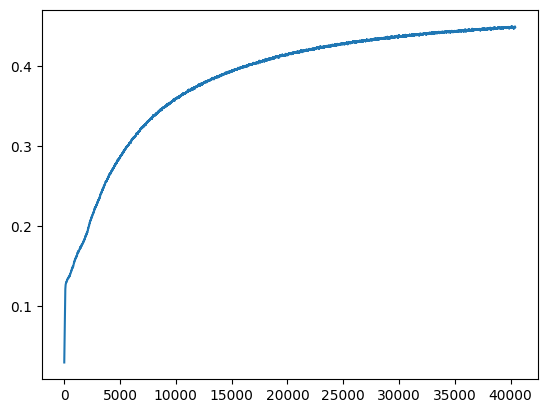

In [24]:
plt.plot(np.convolve(corrs, [1]*100, "valid")/100, )

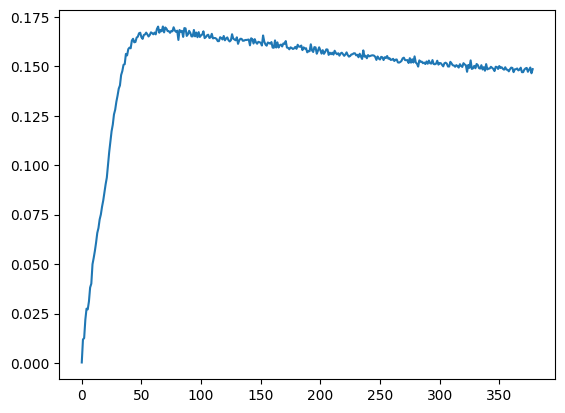

In [27]:
plt.plot(np.hstack(val_corrs))

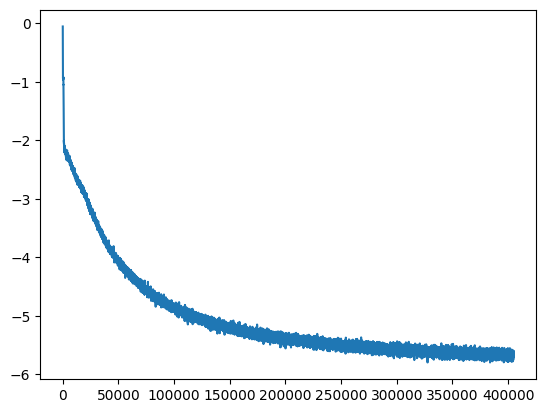

In [25]:
plt.plot(np.convolve(losses, [1]*100, "valid")/100, )

In [55]:
from experanto.configs import DEFAULT_CONFIG as cfg
cfg.dataset.global_chunk_size = 8
cfg.dataset.global_sampling_rate = 8
cfg.dataset.modality_config.screen.include_blanks=False
cfg.dataset.modality_config.screen.sample_stride=8
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}

cfg.dataloader.num_workers=4
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=32
cfg.dataloader.pin_memory=True
# the multiple dataloader is an iterator that returns a tuple of (key, batch)
val_dl = get_multisession_dataloader(full_paths[3:4], cfg)

In [56]:
val_step()

105it [00:08, 12.91it/s]


np.float64(0.3364250884756036)

# Another 200 steps

In [ ]:
for train_loop in range(200):
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        #with autocast(device_type='cuda', dtype=torch.bfloat16):
        #    out = opt_r(videos, k);
        #    loss = criteria(out.transpose(1,2), responses)
        out = opt_r(videos, k);
        loss = criteria(out.transpose(1,2), responses)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(opt_r.parameters(), max_norm=1.0, norm_type=2)
        opt.step()

        
        opt.zero_grad()
        losses.append(loss.item())
        with warmup_scheduler.dampening():
            lr_scheduler.step()
        
        if i % 10 ==0:
            r2 = responses.to(torch.float32).cpu().numpy().flatten()
            r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
            corrs.append(np.corrcoef(r1,r2)[0,1].item())
            lrs.append(opt.param_groups[0]['lr'])
        if i % 100 ==0:
            print(np.corrcoef(r1,r2)[0,1].item())
    for k, v in train_dl.loaders.items():
        v.dataset.shuffle_valid_screen_times()

1it [00:00,  2.82it/s]

0.2493495497672485


101it [00:28,  3.36it/s]

0.24698720524257822


201it [00:55,  3.37it/s]

0.2548009030297455


301it [01:23,  3.37it/s]

0.25241333779929065


331it [01:32,  3.40it/s]

In [29]:
losses, corrs = [], []
for _ in tqdm(range(200)):
    
    videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
    responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
    with autocast("cuda", )
        out = opt_r.generate(videos, k);
    loss = criteria(out.transpose(1,2), responses)
    scaler.scale(loss).backward()
    scaler.step(opt)
    scaler.update()
    opt.zero_grad()
    losses.append(loss.item())
    neuron=0
    r2 = responses.to(torch.float32).cpu().numpy().flatten()
    r1 = out.transpose(1,2).detach().cpu().to(torch.float32).numpy().flatten()
    corrs.append(np.corrcoef(r1,r2)[0,1].item())

  0% 0/500 [00:00<?, ?it/s]


RuntimeError: "_amp_foreach_non_finite_check_and_unscale_cuda" not implemented for 'BFloat16'

## Overfitting

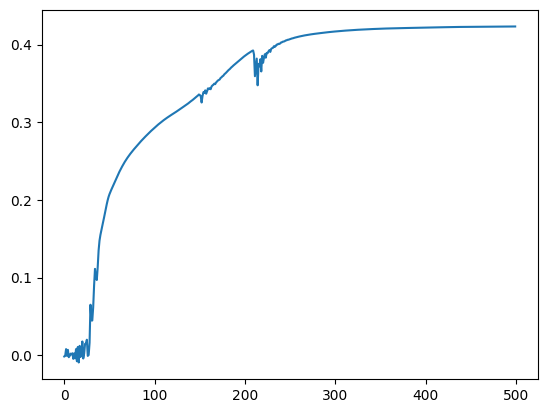

In [16]:
plt.plot(corrs)

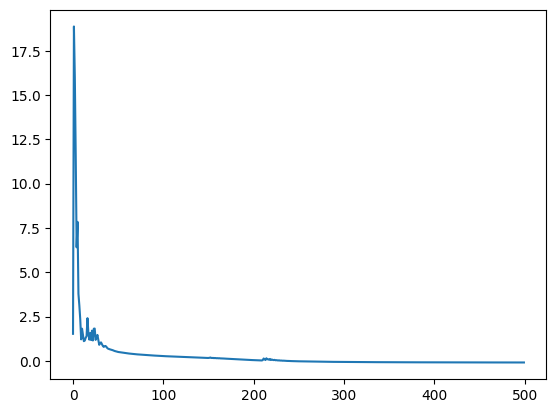

In [17]:
plt.plot(losses)

In [24]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

7it [00:14,  2.00s/it]/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:168: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
8it [00:22,  4.01s/it]W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] torch._dynamo hit config.cache_size_limit (8)
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8]    function: 'forward' (/tmp/ipykernel_20839/2467812288.py:21)
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8]    last reason: 0/0: L['key'] == '29513-3-5'                                     
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1015 15:32:29.407000 20839 torch/_dynamo/convert_frame.py:844] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch

In [25]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

201it [00:09, 22.31it/s]


In [106]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = opt_r(videos, k);
        if i > 200:
            break

201it [00:08, 22.55it/s]


In [30]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        out = tiny_hiera(videos,);
        if i > 200:
            break

201it [00:03, 52.64it/s]


In [ ]:
opt.zero_grad()


In [193]:
videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)

In [194]:
from torch.amp import autocast

In [182]:
opt_r.to(torch.bfloat16);

In [183]:
with autocast(device_type='cuda', dtype=torch.float16):
    out = opt_r(videos, k);


In [57]:
out.shape

torch.Size([8, 7495, 16])

In [58]:
loss = criteria(out.transpose(1,2), responses)

In [59]:
loss.backward()

In [61]:
opt.step()

In [63]:
opt.zero_grad()

In [65]:
loss.shape

torch.Size([])

In [186]:
videos.shape

torch.Size([8, 1, 16, 144, 256])

In [196]:
opt_r = opt_r.to(torch.bfloat16)

In [197]:
out = opt_r(videos, k);

In [ ]:
out = opt_r(videos, k);

In [ ]:
losses = []
for _ in tqdm(range(1000)):
    #with autocast(device_type='cuda', dtype=torch.bfloat16):
    videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
    responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
    out = opt_r(videos, k);
    loss = criteria(out.transpose(1,2), responses)
    loss.backward()
    opt.step()
    opt.zero_grad()
    losses.append(loss.item())

 58% 576/1000 [01:24<01:01,  6.84it/s]

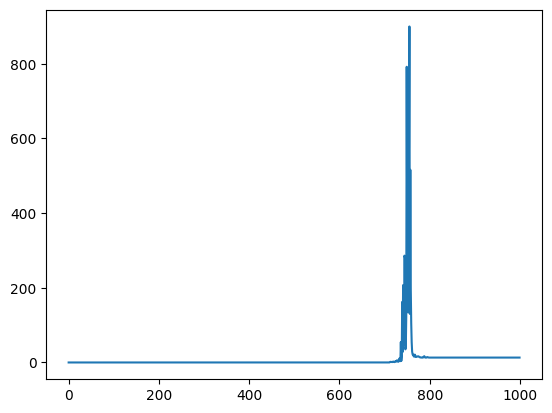

In [218]:
plt.plot(losses)

In [141]:
out.shape

torch.Size([8, 7495, 16])

In [142]:
responses.shape

torch.Size([8, 16, 7495])

In [51]:
neuron=66

0.12096827660364878

In [38]:
out.shape

torch.Size([8, 7495, 16])

In [ ]:
for batch_no, (data_key, data) in tqdm(enumerate(LongCycler(dataloaders["train"])), total=n_iterations,
                                       desc="Epoch {}".format(epoch)):

    loss = full_objective(model, dataloaders["train"], data_key, *data)
    # loss = torch.sum(loss)
    loss.backward()

In [33]:
full_out.shape

torch.Size([8, 7671, 16])

In [ ]:
r.readout["29513-3-5"].bias.shape

In [97]:
full_out = rearrange(full_out, 'b (n t) c -> b t n c', n=7671, t=16)

In [49]:
full_out.shape

torch.Size([8, 16, 7671, 384])

In [50]:
w = r.readout["29513-3-5"].weight

In [51]:
w.shape

torch.Size([7671, 256, 1])

In [54]:
torch.einsum("btni, njr->bnt", full_out, w, )

torch.Size([8, 7671, 16])

In [93]:
full_out.shape

torch.Size([8, 7671, 256])

In [75]:
torch.isnan(full_out).sum()

tensor(960416, device='cuda:0')

In [37]:
with torch.no_grad():
    for i in tqdm(range(100)):
        r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 110.38it/s]


In [39]:
with torch.no_grad():
    for i in tqdm(range(100)):
        r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 110.43it/s]


In [43]:
for i in tqdm(range(100)):
    r(videos, "29513-3-5");

100% 100/100 [00:00<00:00, 103.98it/s]


In [29]:
import torch
n_params=0
for n, p in r.readout.named_parameters():
    print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

29513-3-5.query torch.Size([1, 8, 7671, 32]) 1963776
29513-3-5.weight torch.Size([7671, 256, 1]) 1963776
29513-3-5.bias torch.Size([1, 7671, 1]) 7671
29514-2-9.query torch.Size([1, 8, 7495, 32]) 1918720
29514-2-9.weight torch.Size([7495, 256, 1]) 1918720
29514-2-9.bias torch.Size([1, 7495, 1]) 7495
29755-2-8.query torch.Size([1, 8, 8122, 32]) 2079232
29755-2-8.weight torch.Size([8122, 256, 1]) 2079232
29755-2-8.bias torch.Size([1, 8122, 1]) 8122
29647-19-8.query torch.Size([1, 8, 8202, 32]) 2099712
29647-19-8.weight torch.Size([8202, 256, 1]) 2099712
29647-19-8.bias torch.Size([1, 8202, 1]) 8202
29156-11-10.query torch.Size([1, 8, 7440, 32]) 1904640
29156-11-10.weight torch.Size([7440, 256, 1]) 1904640
29156-11-10.bias torch.Size([1, 7440, 1]) 7440
29623-4-9.query torch.Size([1, 8, 7908, 32]) 2024448
29623-4-9.weight torch.Size([7908, 256, 1]) 2024448
29623-4-9.bias torch.Size([1, 7908, 1]) 7908
29515-10-12.query torch.Size([1, 8, 7863, 32]) 2012928
29515-10-12.weight torch.Size([7863,

In [23]:
full_out.shape

torch.Size([8, 7671, 256])

In [38]:
30684/16

1917.75

In [ ]:
30684

In [35]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            r(videos, "29513-3-5")

torch.Size([8, 4, 18, 16, 384])
torch.Size([8, 1152, 256])
torch.Size([8, 1152, 256])
torch.Size([32, 8, 7671, 32])
torch.Size([8, 8, 1152, 32])
torch.Size([8, 8, 1152, 32])


In [42]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            r(videos, "29513-3-5")

100% 100/100 [00:00<00:00, 110.38it/s]


In [20]:
example_in = torch.ones(32,1,16,144, 144).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(1000)):
        tiny_hiera(example_in);

100% 1000/1000 [00:21<00:00, 46.31it/s]


In [11]:
24*32*16

12288

In [22]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(dl)):
        video_tensor = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        _ = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["eye_tracker"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["treadmill"].to("cuda", torch.bfloat16, non_blocking=True)
        #tiny_hiera(video_tensor);
        if i >300:
            break

301it [00:17, 17.03it/s]


In [24]:
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(dl)):
        video_tensor = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        _ = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["eye_tracker"].to("cuda", torch.bfloat16, non_blocking=True)
        _ = b["treadmill"].to("cuda", torch.bfloat16, non_blocking=True)
        tiny_hiera(video_tensor);
        if i >300:
            break

301it [00:22, 13.28it/s]


In [25]:
import torch
n_params=0
for n, p in tiny_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

4891336


In [2]:
import hiera

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from hiera import Hiera


In [3]:
hiera

<module 'hiera' from '/usr/local/lib/python3.10/dist-packages/hiera/__init__.py'>

In [1]:
from hiera import Hiera
model = Hiera.from_pretrained("facebook/hiera_base_224.mae_in1k_ft_in1k")  # mae pt then in1k ft'd model
model = Hiera.from_pretrained("facebook/hiera_base_224.mae_in1k") # just mae pt, no ft

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = Hiera.from_pretrained("facebook/hiera_tiny_224.mae_in1k") # just mae pt, no ft

In [3]:

import torch
from hiera import Hiera
my_tiny_hiera = Hiera(embed_dim=96, num_heads=1, stages=(1, 2, 7, 2))

In [4]:
my_cut_hiera = Hiera(input_size=(16,144, 144),
                     num_heads=1, 
                     stages=(1, 2, 2), 
                     q_pool=1, 
                     in_chans=1,
                     q_stride=(1, 2, 2),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(3, 7, 7),
                     patch_stride=(2, 4, 4),
                     patch_padding=(1, 3, 3),
                     sep_pos_embed=True,)

In [5]:
my_cut_hiera.eval().cuda().to(torch.bfloat16);

In [6]:
from tqdm import tqdm

In [11]:
example_in = torch.ones(32,1,16,144, 144).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(1000)):
        my_cut_hiera(example_in);

 19% 193/1000 [00:15<01:06, 12.07it/s]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f167ca8b370>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [125]:
out = my_cut_hiera(torch.ones(1,1,16,144,144).cuda(), return_intermediates=True)

In [122]:
(out[1])[1].shape

torch.Size([1, 8, 18, 18, 192])

In [81]:
36*4

144

In [69]:
my_cut_hiera.head.projection.weight.shape

torch.Size([1000, 384])

In [75]:
import numpy as np

In [76]:
np.sqrt(384)

np.float64(19.595917942265423)

In [40]:
%debug

> /usr/local/lib/python3.10/dist-packages/hiera/hiera.py(413)forward()
    411             else None,
    412         )
--> 413         x = x + self.get_pos_embed()
    414         x = self.unroll(x)
    415 



ipdb>  x.shape


torch.Size([1, 3888, 96])


ipdb>  self.get_pos_embed().shape


torch.Size([1, 10368, 96])


ipdb>  q


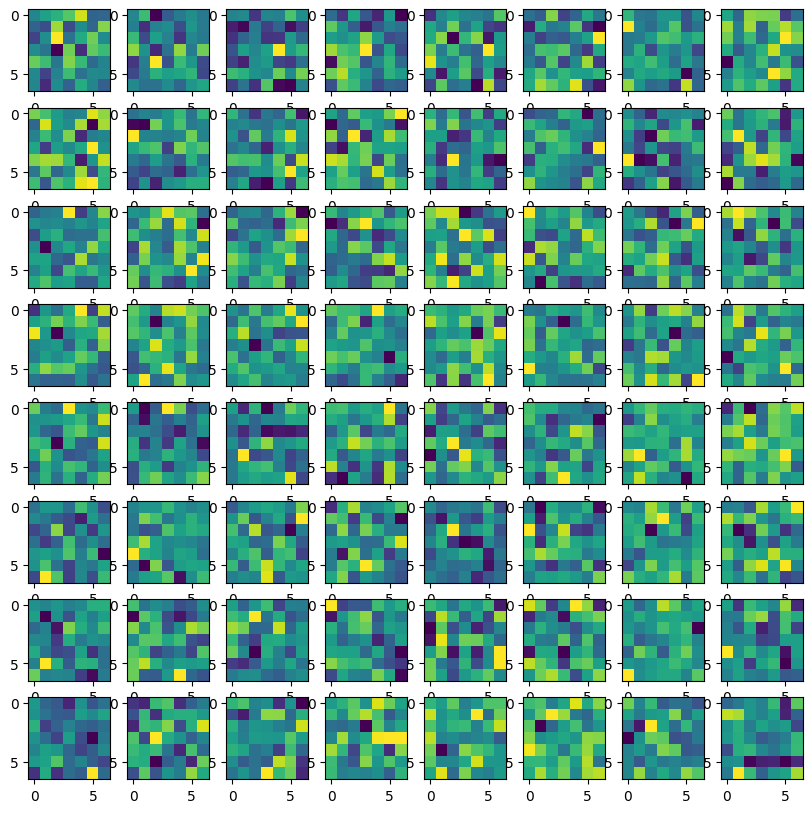

In [83]:
fig, axs = plt.subplots(8,8, figsize=(10,10))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(my_cut_hiera.patch_embed.proj.weight.data[i,0].cpu().numpy())

In [2]:
import torch

In [7]:
some_weights = torch.load("mae_hiera_tiny_224.pth")
my_cut_hiera.load_state_dict(some_weights["model_state"], strict=False)


/tmp/ipykernel_248295/1124240724.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  some_weights = torch.load("mae_hiera_tiny_224.pth")


RuntimeError: Error(s) in loading state_dict for Hiera:
	size mismatch for pos_embed: copying a param with shape torch.Size([1, 3136, 96]) from checkpoint, the shape in current model is torch.Size([1, 2304, 96]).

In [ ]:
fig, axs = plt.subplots(8,12, figsize=(12,8))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(my_cut_hiera.patch_embed.proj.weight.data[i,2].cpu().numpy(), cmap="hot")
    ax.axis("off")

In [8]:
n_params=0
for n, p in my_tiny_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

27910216


In [9]:
n_params=0
for n, p in model.named_parameters():
    print#(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

27910216


In [10]:
n_params=0
for n, p in my_cut_hiera.named_parameters():
    #print(n, p.shape, torch.numel(p))
    n_params += torch.numel(p)
print(n_params)

4987336


In [11]:
my_cut_hiera.to("cuda", torch.bfloat16);
my_tiny_hiera.to("cuda", torch.bfloat16);


In [12]:
from tqdm import tqdm

In [13]:
with torch.no_grad():
    for i in tqdm(range(100)):
        my_cut_hiera(torch.ones(500,3,256,144).to("cuda", torch.bfloat16));

100% 100/100 [00:16<00:00,  6.09it/s]


In [15]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.48it/s]


In [16]:
my_tiny_hiera = torch.compile(my_tiny_hiera,)

In [9]:
my_tiny_hiera.to("cuda", torch.bfloat16);
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
out = my_tiny_hiera(example, );

In [19]:
# default
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.60it/s]


In [21]:
torch.set_float32_matmul_precision('high')
# default
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.64it/s]


In [22]:
torch.set_float32_matmul_precision('medium')

In [24]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)


100% 100/100 [00:13<00:00,  7.63it/s]


In [30]:
example = torch.ones(500,3,224,224).to("cuda", torch.bfloat16)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.65it/s]


In [32]:
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            out = my_tiny_hiera(example, );

100% 100/100 [00:13<00:00,  7.65it/s]


In [36]:
torch.backends.cuda.enable_flash_sdp(False)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.46it/s]


In [37]:
torch.backends.cuda.enable_flash_sdp(True)
with torch.no_grad():
    for i in tqdm(range(100)):
        out = my_tiny_hiera(example, );

100% 100/100 [00:22<00:00,  4.37it/s]


In [4]:
import torch

In [15]:
example.shape


torch.Size([500, 3, 224, 224])

In [5]:
torch.__version__

'2.6.0.dev20240913+cu121'

In [14]:
%debug

> /usr/local/lib/python3.10/dist-packages/hiera/hiera.py(100)forward()
     98         if hasattr(F, "scaled_dot_product_attention"):
     99             # Note: the original paper did *not* use SDPA, it's a free boost!
--> 100             x = F.scaled_dot_product_attention(q, k, v)
    101         else:
    102             attn = (q * self.scale) @ k.transpose(-1, -2)



ipdb>  F


<module 'torch.nn.functional' from '/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py'>


ipdb>  k.shape


torch.Size([500, 1, 49, 64, 96])


ipdb>  q


In [21]:
from tqdm import tqdm
torch.set_float32_matmul_precision('medium')
from torch.nn.attention import SDPBackend, sdpa_kernel
with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    with torch.no_grad():
        for i in tqdm(range(100)):
            out = my_tiny_hiera(torch.ones(10,3,224,224).to("cuda", torch.bfloat16), );

  0% 0/100 [00:00<?, ?it/s]


RuntimeError: No available kernel. Aborting execution.

In [2]:
128*8*3*224*224*2 / 1e9

0.308281344

In [ ]:
! 

In [ ]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))